In [37]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error


import operator
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42)
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH = 12
WIDTH = 0.25  # the width of the bars
NARROW = 0.2
XLINE  = 523.21
YLINE  = 0.002
#colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']
colors = ['b','b']
# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]
markersize=20

In [24]:
def get_joined_data():
    """Returns single (joined) dataframe"""
    
    # Combining V100 and P100 on same row for same run
    # We are deleting cases where there is no run for either of the architectures
    # Every column name is appended with the name of the architecture (e.g. "_V100");
    # This includes the `master_index` (e.g `master_index_V100`)

    df_joined = pd.read_parquet('../df_master_joined.parquet')
    df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
    df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
    #import pdb; pdb.set_trace()
    return df_joined

def filter_lt_val(df, val=1e9):
    ##temp_col = df['dram_write_throughput_V100'] + df['dram_read_throughput_V100']
    #temp_col3 = df_joined['dram_write_throughput_V100'] + df_joined['dram_read_throughput_V100']
    #temp_col = df['dram_write_throughput_P100']
    #temp_col2 = df['dram_read_throughput_P100']
    temp_col4 = df['dram_write_throughput_V100']
    temp_col5 = df['dram_read_throughput_V100'] ## trouble predicting read throughput MAPE=.55 with dram read< 1e9
    #df =df[temp_col>val]
    #df =df[temp_col2>val]
    return df,operator.and_(temp_col4>val,temp_col5>val).values
    import pdb; pdb.set_trace()
    df =df[temp_col4>val]
    df =df[temp_col5>val]
    #df_joined = df_joined[temp_col3>1e9]
    #return df[temp_col > val]
    return df

_columns = None
def get_columns():
    global _columns
    # This is an "empty" dataframe (meaning no rows), containing
    # column names for numerical data only.
    # The column nmaes can be used to index the columns of the
    # scaled data (in master_scaled_data.npy)
    if _columns is None:
        _columns = tuple(pd.read_parquet('../df_column_reference.parquet').columns)
    return _columns


_scaled_data = None
def get_scaled_data(row_index):
    global _scaled_data
    # This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
    # The data has been scaled using the StandardScaler in scikitlearn

    # Notes: 
    #   - The row indices correspond to the `master_index` column of 'df_master.parquet'
    #   - The columns correspond to the columns in 'df_column_reference.parquet'.
    #     (e.g. can use `df.get_loc(column-name)` to get the column index)

    if _scaled_data is None:
        _scaled_data = np.load('../master_scaled_data.npy')
    return _scaled_data[row_index]

def get_data(filter_val=10e9):
    """Returns full data and target vector"""
    
    df = get_joined_data()  # Start with all of df_joined
    
    df,filtered = filter_lt_val(df, filter_val)  # Filter throughput < 1e9
    
    # Training data index and values (values ARE in master_data_scaled)
    data_row_index = df['master_index_P100'].values
    data = get_scaled_data(data_row_index)
    col_indices = []
    for i, col in enumerate(get_columns()):
        if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
            col_indices.append(i)
    data = data[:, col_indices]

    #target_row_index = df['master_index_V100'].values
    #target = get_scaled_data(target_row_index)      
    #target_col_indices = []
    #for i, col in enumerate(get_columns()):
    #    if col in ['dram_read_throughput', 'dram_write_throughput']:
    #        target_col_indices.append(i)
    #target = target[:, target_col_indices[0]] + target[:, target_col_indices[1]]
    ref = (df['dram_read_throughput_V100'] + df['dram_write_throughput_V100']).values
    p100_total_throughput = (df['dram_read_throughput_P100'] + df['dram_write_throughput_P100']).values
    scaler = StandardScaler()
    scaler.fit(ref.reshape(-1, 1))
    target = scaler.transform(ref.reshape(-1, 1)).reshape(ref.shape)

    return data, target, scaler,filtered,p100_total_throughput,ref

def graph_data(x,y,xlabel,ylabel,title,file,num_features=False):
    plt.plot(x, y,'.',color='b',markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if num_features:
        plt.title(title + " - " + num_features + " Features")
    else:
        plt.title(title)
    plt.savefig("Clean_figures/" + file + ".pdf")

## Getting data

In [20]:
data, target, scaler,filtered,p100_tt, v100_tt = get_data(filter_val=0)


## Baseline

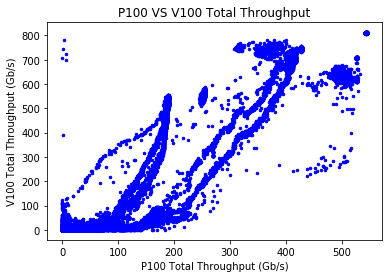

In [26]:
graph_data(
    p100_tt/1e9,
    v100_tt/1e9,
    "P100 Total Throughput (Gb/s)", 
    "V100 Total Throughput (Gb/s)",
    "P100 VS V100 Total Throughput", 
    "p100_vs_v100_TT")


## Splitting data 

In [29]:
(
    X_train, X_test,
    y_train, y_test,
    filtered_train,
    filtered_test,
) = train_test_split(
    data,
    target,
    filtered,
    random_state=42,
    test_size=.33
)
data.shape

(32291, 112)

In [31]:
filtering = True # Removing target values of 0 
if filtering:
    y_test_filtered = y_test[filtered_test]
    X_test_filtered = X_test[filtered_test]
    #y_train_filtered = y_train[filtered_test]
    #X_train_filtered = X_train[filtered_test]

## Train & Predict with RF model

In [32]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [33]:
if filtering:
    y_test_predict = clf.predict(X_test_filtered)
else:
    y_test_predict = clf.predict(X_test)

## Rescaling results

In [35]:
if filtering:
    y_test_bytes =  scaler.inverse_transform(y_test_filtered)/1e9
    y_test_predict_bytes =  scaler.inverse_transform(y_test_predict)/1e9
else:
    y_test_bytes =  scaler.inverse_transform(y_test)/1e9
    y_test_predict_bytes =  scaler.inverse_transform(y_test_predict)/1e9
errors = abs(y_test_predict_bytes - y_test_bytes)

## Graph and Error Results

### Prediction Result Graphs

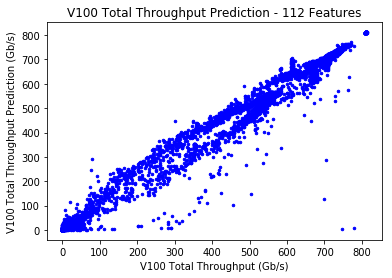

In [43]:
graph_data(
    y_test_bytes, 
    y_test_predict_bytes,
    "V100 Total Throughput (Gb/s)", 
    "V100 Total Throughput Prediction (Gb/s)",
    "V100 Total Throughput Prediction", 
    "p100_vs_v100_results_all_data-112features", 
    num_features='112')

### Median absolute error

In [38]:
median_absolute_error(y_test_bytes, y_test_predict_bytes)

5.936780201583925

### Mean absolute error

In [39]:
mean_absolute_error(y_test_bytes, y_test_predict_bytes)

15.320499822271104

### Absolute Error Graph

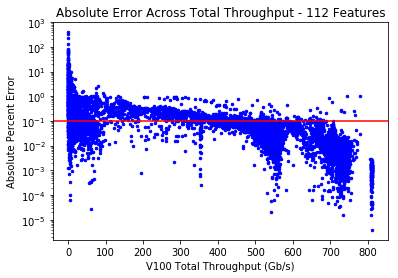

In [45]:
graph_data(
    y_test_bytes, 
    (errors/y_test_bytes),
    "V100 Total Throughput (Gb/s)", 
    "Absolute Percent Error",
    "Absolute Error Across Total Throughput", 
    "absolute_error_all_data-112features", 
    num_features='112')

plt.yscale("log")
plt.axhline(y=.1, color='r', linestyle='-')